# Kernels demo


In [ ]:
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
%matplotlib inline

from plot_classifier import plot_classifier

%autosave 0

## "Other normal equations" demo

- The normal equations: $$w=(X^TX+\lambda I)^{-1}X^Ty$$
- Alternate form: $$w=X^T(XX^T+\lambda I)^{-1}y$$

Let's test this out:

In [ ]:
n = 1000
d = 10
X = npr.randn(n,d)
y = npr.rand(n)

λ=1

In [88]:
w1 = np.linalg.solve(X.T@X + λ*np.eye(d), X.T@y)
w1

array([-0.00777902,  0.00895081,  0.02043244, -0.01806816,  0.019294  ,
        0.00230314,  0.00233585, -0.00322085,  0.00128307,  0.01928348])

In [89]:
w2 = X.T@np.linalg.solve(X@X.T+λ*np.eye(n), y)
w2

array([-0.00777902,  0.00895081,  0.02043244, -0.01806816,  0.019294  ,
        0.00230314,  0.00233585, -0.00322085,  0.00128307,  0.01928348])

In [90]:
np.allclose(w1,w2)

True

This isn't a proof but they seem to yield the same results for this randomly generated dataset.

## Number of polynomial features


In [ ]:
n = 2
d = 4
p = 3

X = npr.randn(n,d)
y = npr.randn(n)

pf = PolynomialFeatures(degree=p)
Z = pf.fit_transform(X)
Z.shape

Above: we get $k=35$ as in the slides.

## Polynonial kernel vs. polynomial features (for regression)


In [91]:
n = 10
x = np.random.rand(n)
y = x**2 + np.random.randn(n)*.1

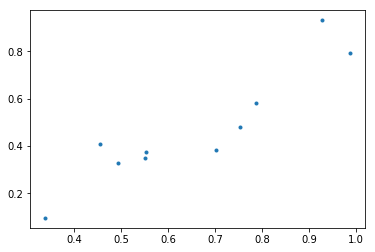

In [92]:
plt.plot(x,y,'.');

In [93]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

k=10  # polynomial degree
λ=1e-10 # L2 regularization strength

X = x[:,None]
pf = PolynomialFeatures(degree=k)
Z = pf.fit_transform(X)

ridge = Ridge(alpha=λ, fit_intercept=False) 
# fit_intercept=False because features already include intercept feature
# could alternatively set include_bias=False for the PolynomialFeatures
ridge.fit(Z,y)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

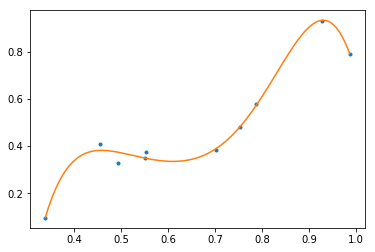

In [94]:
# grid = np.linspace(0,1,1000)[:,None]
grid = np.linspace(np.min(x),np.max(x),1000)[:,None]
plt.plot(x,y,'.')
plt.plot(grid, ridge.predict(pf.transform(grid)));

In [95]:
ridge.coef_

array([ -24.31354986,  202.05238535, -619.50582657,  780.47608093,
        -64.81219613, -610.3731211 ,    6.23091342,  569.73479582,
        142.41968717, -646.85587342,  265.65894704])

#### And now the same with a kernel

In [96]:
kr = KernelRidge(alpha=λ, kernel='polynomial', degree=k)
kr.fit(X,y)

KernelRidge(alpha=1e-10, coef0=1, degree=10, gamma=None, kernel='polynomial',
      kernel_params=None)

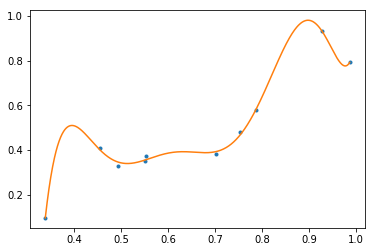

In [97]:
plt.plot(x,y,'.')
plt.plot(grid, kr.predict(grid));

There are slight differences due to different implementations and different interpretations of $\lambda$, but they are essentially the same.

### RBF kernel vs. RBF features

Next we'll try to show how the RBF kernel relates to the RBF features. We implement the RBF features (from Lecture 14) below, and compare with the above. 

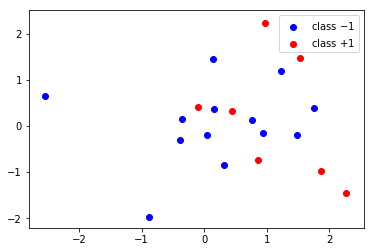

In [98]:
# generate synthetic 2D data set
npr.seed(0)
n = 20
X = npr.randn(n,2)
y = npr.choice((-1,+1),size=n)

plt.scatter(X[y<0,0], X[y<0,1], color="b", label="class $-1$")
plt.scatter(X[y>0,0], X[y>0,1], color="r", label="class $+1$")
plt.legend(loc="best")
plt.show()

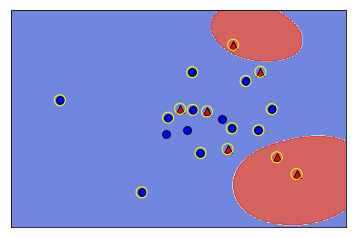

In [100]:
svm = SVC(kernel="rbf")
svm.fit(X,y)
plot_classifier(X, y, svm,ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

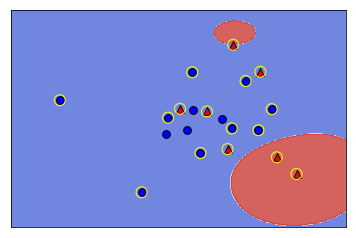

In [101]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

def RBF_features(Xtrain, Xtest, sigma=1):
    return np.exp(-0.5*euclidean_dist_squared(Xtest,Xtrain)/(sigma**2))

Z = RBF_features(X,X)
svm2 = SVC(kernel="linear")
svm2.fit(Z,y)
plot_classifier(X, y, svm2, transformation=lambda Xtest: RBF_features(X,Xtest), ax=plt.gca())
plt.scatter(*X[svm2.support_].T, marker="o", edgecolor="yellow", facecolor="none", s=120);

They look pretty similar. Let's time them though. 

In [102]:
n = 1000
d = 10
X = npr.randn(n,d)
y = npr.choice((-1,+1),size=n)

svm = SVC(kernel="rbf")

%timeit svm.fit(X,y)

40.1 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%timeit svm.predict(X)

24.3 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
Z = RBF_features(X,X)
svm2 = SVC(kernel="linear")

%timeit svm2.fit(Z,y)

1.39 s ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit svm2.predict(Z)

1.35 s ± 96.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
